# Highly-multiplexed image analysis with Harpy

In this notebook we will import an unprocessed spatial proteomics dataset from the MACSima platform and perform some cell segmentation and feature calculation using Harpy.


In [1]:
# To run this notebook with CUDA, install dask-cuda:
#    uv pip install dask-cuda==24.12.0
#
# We pin to this version because spatialdata requires
# dask>=2024.10.0,<=2024.11.2, and dask-cuda 24.12.0
# is the latest release compatible with that range.


from matplotlib import pyplot as plt

import harpy as hp

## 1. Load the example dataset

The example dataset for this notebook will be downloaded and cached using `pooch` via `harpy.dataset.registry`. The dataset is a small subset of a larger dataset that was generated using the MACSima platform.


In [2]:
sdata = hp.datasets.macsima_example()
sdata

/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/Users/arnedf/VIB/harpy/src/harpy/datasets/proteomics.py:32: UserWarning: SpatialData is not stored in the most current format. If you want to use Zarr v3, please write the store to a new location using `sdata.write()`.
  sdata = read_zarr(os.path.commonpath(unzip_path))
2025-11-07 14:31:49,362 - harpy.image._manager - INFO - Writing results to layer 'HumanLiverH35'


SpatialData object
└── Images
      └── 'HumanLiverH35': DataArray[cyx] (151, 1000, 1000)
with coordinate systems:
    ▸ 'global', with elements:
        HumanLiverH35 (Images)

Spatial proteomics usually differs from spatial transcriptomics in that the data is mostly highly-multiplexed images instead of just a cell staining and gene transcript locations. In this subsetted example dataset we have an image of 1000 by 1000 pixels and 151 channels from 51 staining rounds. With one DAPI stain per round, there are 100 markers of interest.


In [3]:
marker_names = sdata["HumanLiverH35"].coords["c"].values.tolist()
print(len(marker_names))
", ".join(marker_names)

151


'R0 DAPI, R1 DAPI, R1 VSIG4, R1 CD14, R2 DAPI, R2 CD163, R3 DAPI, R3 CD11c, R3 CD335, R4 DAPI, R4 CD141, R5 DAPI, R5 CD169, R5 CD49d, R6 DAPI, R6 CD279, R7 DAPI, R7 CD4, R7 CD41a, R8 DAPI, R8 CD16b, R9 DAPI, R9 CD26, R9 CD133, R10 DAPI, R10 CD36, R11 DAPI, R11 CD68, R11 CD164, R12 DAPI, R12 CD90, R13 DAPI, R13 Desmin, R13 CD123, R14 DAPI, R14 CD38, R15 DAPI, R15 CD49a, R15 CD1c, R16 DAPI, R16 CD5, R17 DAPI, R17 CD54, R17 CD206, R18 DAPI, R18 CD73, R19 DAPI, R19 CD49b, R19 CD64, R20 DAPI, R20 CD161, R21 DAPI, R21 CD41b, R21 CD55, R22 DAPI, R22 CD56, R23 DAPI, R23 CD105, R23 CD271, R24 DAPI, R24 CD107b, R25 DAPI, R25 CD133, R25 CD13, R26 DAPI, R26 CD11a, R26 CD134, R27 DAPI, R27 CD61, R27 CD177, R27 CD146, R28 DAPI, R28 CD20, R28 CD95, R29 DAPI, R29 CD24, R29 CD196, R29 CD3, R30 DAPI, R30 CD34, R30 CD230, R31 DAPI, R31 CD43, R31 CD243, R31 CD200, R32 DAPI, R32 CD268, R32 CD277, R33 DAPI, R33 CD8, R33 CD28, R33 CD22, R34 DAPI, R34 CD9, R34 CD35, R35 DAPI, R35 CD104, R35 CD235a, R35 CD276,

In [4]:
markers_of_interest = [n for n in marker_names if "DAPI" not in n]
len(markers_of_interest)

100

## 2. Plot the image

We can plot the image to see what it looks like. For this we can use the `harpy.pl.plot_image` function. There is also interoperability with `spatialdata-plot` for advanced visualisation. Note that image intensities are not normalized, so combined plotting of channels may not be very informative.


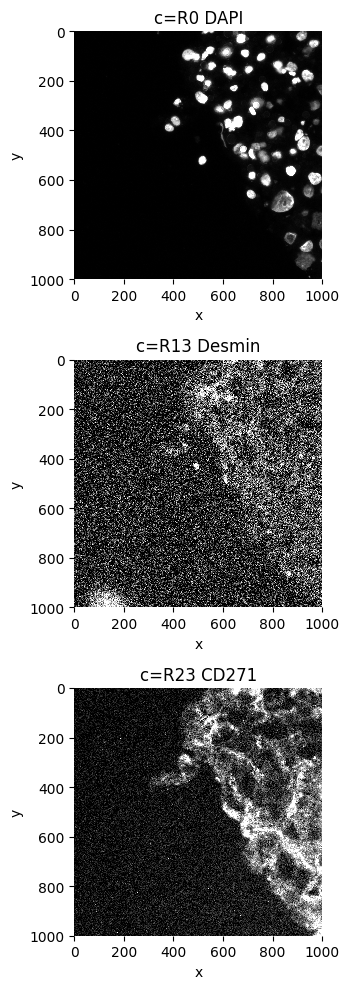

In [5]:
subset_channels = ["R0 DAPI", "R13 Desmin", "R23 CD271"]
hp.pl.plot_image(sdata, img_layer="HumanLiverH35", channel=subset_channels, figsize=(10, 10))

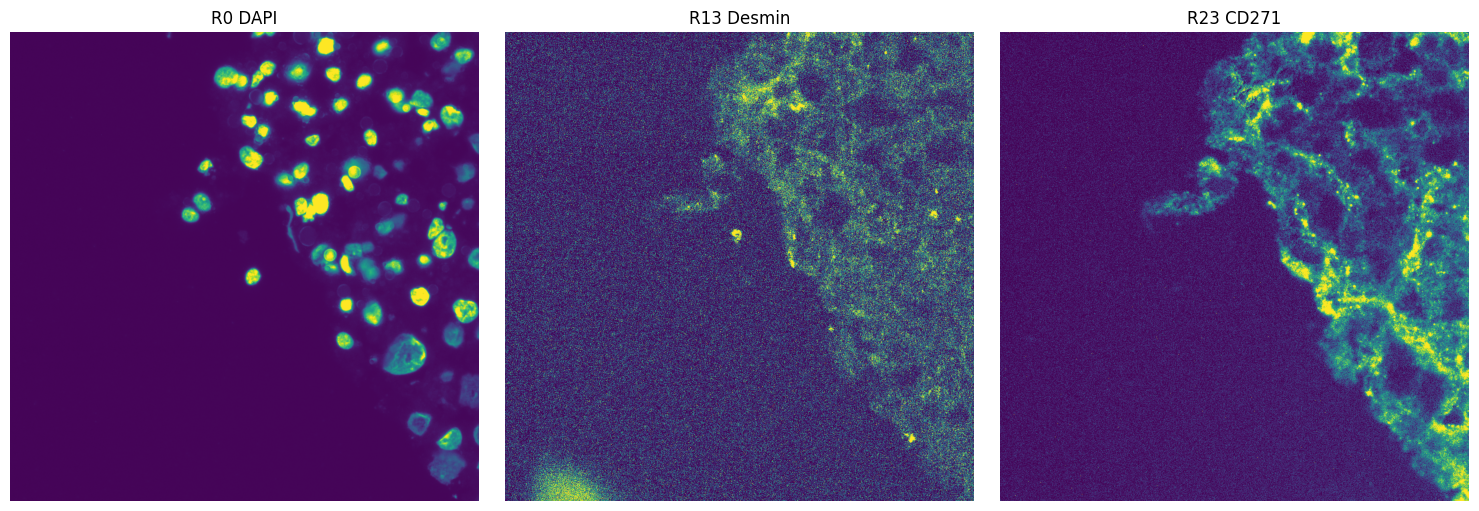

In [6]:
# or using spatialdata-plot:
import numpy as np
from harpy.image._image import _get_spatial_element
import dask.array as da
from matplotlib.colors import Normalize

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for _ax, _channel in zip(axes, subset_channels, strict=True):
    # normalization parameters for visualization (underlying image not changed)
    se = _get_spatial_element(sdata, layer="HumanLiverH35")
    _channel_idx = np.where(sdata["HumanLiverH35"].c.data == _channel)[0].item()
    vmax = da.percentile(se.data[_channel_idx].flatten(), q=99).compute()
    norm = Normalize(vmax=vmax, clip=False)

    render_images_kwargs = {"cmap": "viridis", "norm": norm}
    show_kwargs = {"title": _channel, "colorbar": False}
    _ax = hp.pl.plot_spatialdata(
        sdata,
        img_layer="HumanLiverH35",
        channel=_channel,
        render_images_kwargs=render_images_kwargs,
        show_kwargs=show_kwargs,
        ax=_ax,
    )
    # frameless figure
    _ax.axis("off")

plt.tight_layout()
plt.show()

## 3. Segment using Cellpose


In [7]:
# we first back the spatialdata object to a zarr store:
import os
import tempfile
import uuid

from spatialdata import read_zarr

OUTPUT_DIR = tempfile.gettempdir()

zarr_path = os.path.join(OUTPUT_DIR, f"sdata_{uuid.uuid4()}.zarr")

sdata.write(zarr_path, overwrite=True)
sdata = read_zarr(sdata.path)

In [8]:
import torch
from dask.distributed import Client, LocalCluster

from harpy.image import cellpose_callable

img_layer = "HumanLiverH35"

# Get the DAPI stain, and add it to a new slot.
sdata = hp.im.add_image_layer(
    sdata, arr=sdata[img_layer].sel(c="R0 DAPI").data[None, ...], output_layer="image", overwrite=True
)

if torch.cuda.is_available():
    from dask_cuda import LocalCUDACluster  # pip install dask-cuda

    # One worker per GPU; each worker will be pinned to a single GPU.
    cluster = LocalCUDACluster(
        CUDA_VISIBLE_DEVICES=[0],  # or [0,1],...etc
        n_workers=1,  # 2 if [0,1],...etc
        threads_per_worker=1,
        memory_limit="32GB",
        # local_directory=os.environ.get( "TMPDIR" ),
    )
else:
    # cpu/mps fall back
    from dask.distributed import LocalCluster

    cluster = LocalCluster(
        n_workers=1
        if torch.backends.mps.is_available()
        else 8,  # If mps/cuda device available, it is better to increase chunk size to maximal value that fits on the gpu, and set n_workers to 1.
        # For this dummy example, we only have one chunk, so setting n_workers>1, has no effect.
        threads_per_worker=1,
        memory_limit="32GB",
        # local_directory=os.environ.get( "TMPDIR" ),
    )

client = Client(cluster)

print(client.dashboard_link)

2025-11-07 14:32:05,189 - harpy.image._manager - INFO - Writing results to layer 'image'
/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61852 instead
  warnings.warn(


http://127.0.0.1:61852/status


In [9]:
# segment the DAPI stain
sdata = hp.im.segment(
    sdata,
    img_layer="image",
    depth=200,
    model=cellpose_callable,
    diameter=50,
    flow_threshold=0.8,
    cellprob_threshold=-4,
    output_labels_layer="segmentation_mask",
    output_shapes_layer="segmentation_mask_boundaries",
    overwrite=True,
)

client.close()

/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
pretrained model /Users/arnedf/.cellpose/models/cpsam not found, using default model
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is deprecated in v4.0.1+
2025-11-07 14:32:22,491 - harpy.image.segmentation._segmentation - INFO - Linking labels across chunks.
2025-11-07 14:32:22,497 - harpy.image._manager - INFO - Writing results to layer 'segmentation_mask'
no parent found for <ome_zarr.reader.Label object at 0x36aa8cb60>: None
2025-11-07 14:32:23,049 - harpy.shape._manager - INFO - Finished vectorizing. Dissolving sha

## 4. Visualize resulting segmentation


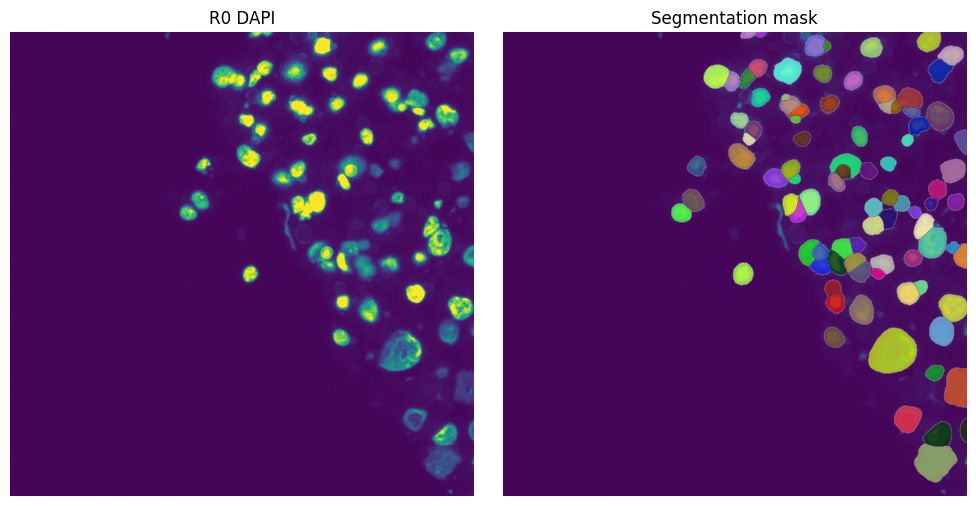

In [10]:
# use hp.pl.plot_spatialdata

import numpy as np
from harpy.image._image import _get_spatial_element
import dask.array as da
from matplotlib.colors import Normalize

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

channel = "R0 DAPI"
# normalization parameters for visualization (underlying image not changed)
se = _get_spatial_element(sdata, layer="HumanLiverH35")
channel_idx = np.where(sdata["HumanLiverH35"].c.data == channel)[0].item()
vmax = da.percentile(se.data[channel_idx].flatten(), q=99).compute()
norm = Normalize(vmax=vmax, clip=False)

render_images_kwargs = {"cmap": "viridis", "norm": norm}
render_labels_kwargs = {"fill_alpha": 0.6, "outline_alpha": 0.4}
show_kwargs = {"title": channel, "colorbar": False}
_ax = hp.pl.plot_spatialdata(
    sdata,
    img_layer="HumanLiverH35",
    channel=channel,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[0],
)
_ax.axis("off")

show_kwargs = {"title": "Segmentation mask", "colorbar": False}
_ax = hp.pl.plot_spatialdata(
    sdata,
    img_layer="HumanLiverH35",
    labels_layer="segmentation_mask",
    channel=channel,
    render_images_kwargs=render_images_kwargs,
    render_labels_kwargs=render_labels_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[1],
)
_ax.axis("off")

plt.tight_layout()
plt.show()

## 5. Feature extraction

Now we have the location of the cells, we can try to extract features from the image to represent the expression of each cell for the marker. There are many different ways to summarize the signal to a single value. When working on spatial proteomics, it is common to use the mean intensity of the pixels in the cell instead of e.g. the count of transcripts. The mean intensity is a simple and fast way to summarize the signal, but it can be sensitive to noise. A more robust way is to use a quantile normalization first to remove intensity outliers and then calculate the mean intensity. Note that we expect the whole-slide image to be already corrected for illumination and background.

You should inspect the normalized images for each channel, as rare or abundant markers may have different distributions and need different q_min and q_max values, which `harpy.im.normalize` supports.


In [11]:
sdata = hp.im.normalize(
    sdata, img_layer="HumanLiverH35", output_layer="HumanLiverH35_normalized_image", q_min=5, q_max=95
)
sdata

2025-11-07 14:33:24,640 - harpy.image._manager - INFO - Writing results to layer 'HumanLiverH35_normalized_image'


SpatialData object, with associated Zarr store: /private/var/folders/q5/7yhs0l6d0x771g7qdbhvkvmr0000gp/T/sdata_a594a150-8b13-45fd-9957-5cfca2572096.zarr
├── Images
│     ├── 'HumanLiverH35': DataArray[cyx] (151, 1000, 1000)
│     ├── 'HumanLiverH35_normalized_image': DataArray[cyx] (151, 1000, 1000)
│     └── 'image': DataArray[cyx] (1, 1000, 1000)
├── Labels
│     └── 'segmentation_mask': DataArray[yx] (1000, 1000)
└── Shapes
      └── 'segmentation_mask_boundaries': GeoDataFrame shape: (92, 1) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        HumanLiverH35 (Images), HumanLiverH35_normalized_image (Images), image (Images), segmentation_mask (Labels), segmentation_mask_boundaries (Shapes)

Calculating the features for every cell is an intensive process and can take a long time. For this small example of 70 cells and 10 channels it can take a couple of seconds. For 51 channels, it can take 30 seconds without additional parallelization. For large whole-slide images, it is recommended to use more cores.


In [12]:
sdata = hp.tb.allocate_intensity(
    sdata,
    img_layer="HumanLiverH35_normalized_image",
    labels_layer="segmentation_mask",
    output_layer="table_intensities",
    mode="mean",
    channels=markers_of_interest[:9],
)
sdata

/Users/arnedf/VIB/harpy/src/harpy/table/_allocation_intensity.py:290: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  adata.obsm[_SPATIAL] = coordinates
/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/spatialdata/_core/spatialdata.py:178: UserWarning: The table is annotating 'segmentation_mask', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


SpatialData object, with associated Zarr store: /private/var/folders/q5/7yhs0l6d0x771g7qdbhvkvmr0000gp/T/sdata_a594a150-8b13-45fd-9957-5cfca2572096.zarr
├── Images
│     ├── 'HumanLiverH35': DataArray[cyx] (151, 1000, 1000)
│     ├── 'HumanLiverH35_normalized_image': DataArray[cyx] (151, 1000, 1000)
│     └── 'image': DataArray[cyx] (1, 1000, 1000)
├── Labels
│     └── 'segmentation_mask': DataArray[yx] (1000, 1000)
├── Shapes
│     └── 'segmentation_mask_boundaries': GeoDataFrame shape: (92, 1) (2D shapes)
└── Tables
      └── 'table_intensities': AnnData (92, 9)
with coordinate systems:
    ▸ 'global', with elements:
        HumanLiverH35 (Images), HumanLiverH35_normalized_image (Images), image (Images), segmentation_mask (Labels), segmentation_mask_boundaries (Shapes)

In [13]:
sdata["table_intensities"].to_df().head()

channels,R1 VSIG4,R1 CD14,R2 CD163,R3 CD11c,R3 CD335,R4 CD141,R5 CD169,R5 CD49d,R6 CD279
cells,,,,,,,,,
38_segmentation_mask_657b959d,0.809246,0.005399,0.071420,0.025679,0.012487,0.031609,0.029887,0.011253,0.029230
39_segmentation_mask_657b959d,0.825022,0.004294,0.059946,0.024327,0.012186,0.034624,0.032157,0.011942,0.026835
41_segmentation_mask_657b959d,0.877863,0.007805,0.081679,0.035323,0.015345,0.035432,0.039999,0.019946,0.031082
42_segmentation_mask_657b959d,0.848713,0.012056,0.074464,0.027920,0.014975,0.035241,0.030530,0.024061,0.031432
44_segmentation_mask_657b959d,0.859654,0.007509,0.068396,0.031179,0.011344,0.032872,0.028308,0.008651,0.031429


We also can extract geometric and morphological information based on the shape of the cells and append it as extra observations to our table. This can be useful to distinguish between different cell types. For example, we can calculate the area of the cell, the perimeter, the eccentricity, the solidity, the major and minor axis.


In [14]:
sdata = hp.tb.add_regionprop_features(sdata, labels_layer="segmentation_mask", table_layer="table_intensities")
sdata["table_intensities"]

/Users/arnedf/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
2025-11-07 14:33:37,734 - harpy.utils._io - WARNING - layer with name 'table_intensities' already exists. Overwriting...


AnnData object with n_obs × n_vars = 92 × 9
    obs: 'cell_ID', 'fov_labels', 'area', 'eccentricity', 'major_axis_length', 'minor_axis_length', 'perimeter', 'centroid-0', 'centroid-1', 'convex_area', 'equivalent_diameter', '_major_minor_axis_ratio', '_perim_square_over_area', '_major_axis_equiv_diam_ratio', '_convex_hull_resid', '_centroid_dif'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [15]:
sdata["table_intensities"].obs.head()

,cell_ID,fov_labels,area,eccentricity,major_axis_length,minor_axis_length,perimeter,centroid-0,centroid-1,convex_area,equivalent_diameter,_major_minor_axis_ratio,_perim_square_over_area,_major_axis_equiv_diam_ratio,_convex_hull_resid,_centroid_dif
cells,,,,,,,,,,,,,,,,
38_segmentation_mask_657b959d,38,segmentation_mask,418.0,0.911566,36.672296,15.077920,87.798990,6.114833,527.631579,438.0,23.069767,2.432185,18.441777,1.589626,0.045662,0.010113
39_segmentation_mask_657b959d,39,segmentation_mask,224.0,0.854401,23.935207,12.437074,60.177670,4.754464,556.080357,231.0,16.888033,1.924505,16.166750,1.417288,0.030303,0.004816
41_segmentation_mask_657b959d,41,segmentation_mask,1832.0,0.625884,54.902127,42.819061,161.053824,19.825328,918.089520,1862.0,48.296737,1.282189,14.158479,1.136767,0.016112,0.002700
42_segmentation_mask_657b959d,42,segmentation_mask,1630.0,0.518932,49.679603,42.466898,158.539105,29.828834,672.452761,1754.0,45.556344,1.169843,15.420029,1.090509,0.070696,0.020818
44_segmentation_mask_657b959d,44,segmentation_mask,1679.0,0.434846,48.848925,43.988686,153.539105,33.885051,794.118523,1732.0,46.236016,1.110488,14.040653,1.056512,0.030600,0.003937


<Axes: >

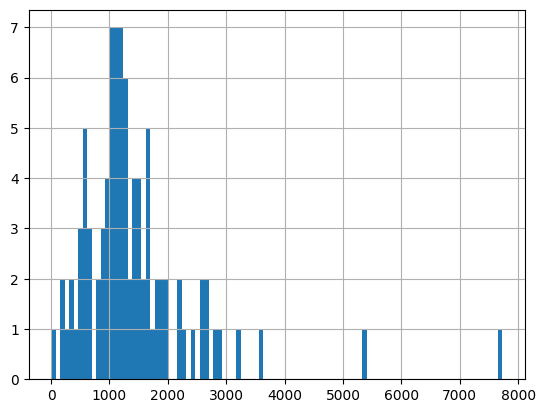

In [16]:
sdata["table_intensities"].obs["area"].hist(bins=100)

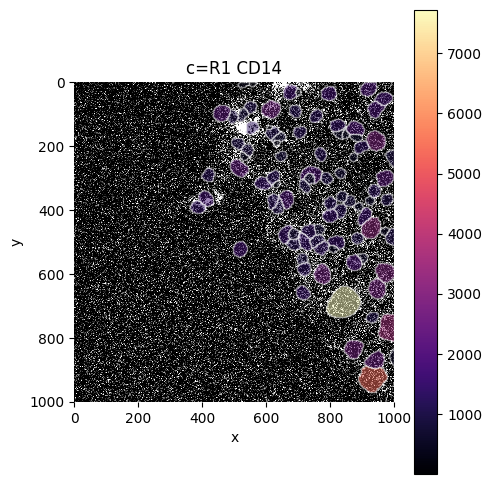

In [17]:
hp.pl.plot_shapes(
    sdata,
    img_layer="HumanLiverH35_normalized_image",
    shapes_layer="segmentation_mask_boundaries",
    table_layer="table_intensities",
    column="area",
    channel="R1 CD14",
    figsize=(5, 5),
)

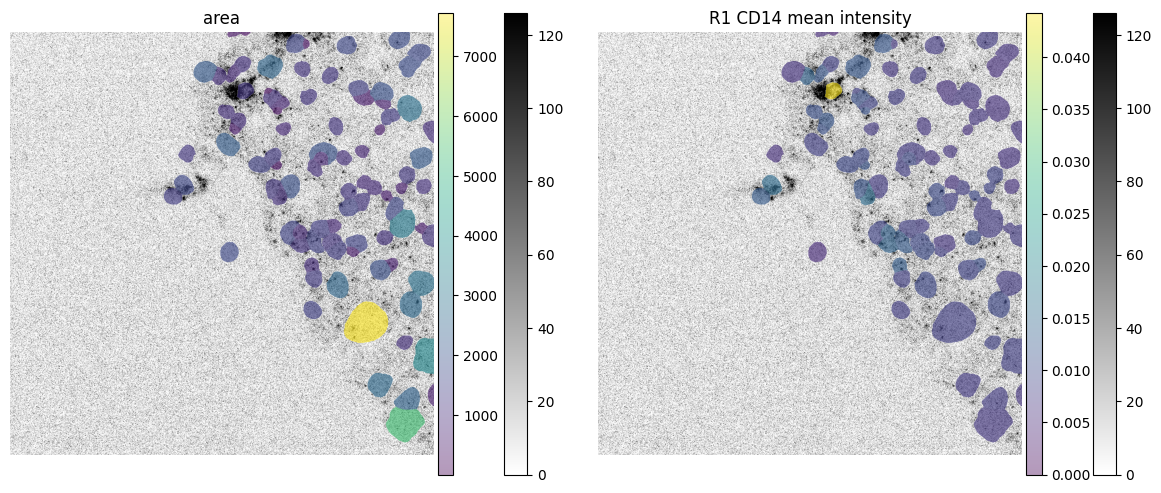

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

channel = "R1 CD14"
# normalization parameters for visualization (underlying image not changed)
se = _get_spatial_element(sdata, layer="HumanLiverH35")
channel_idx = np.where(sdata["HumanLiverH35"].c.data == channel)[0].item()
vmax = da.percentile(se.data[channel_idx].flatten(), q=99).compute()
norm = Normalize(vmax=vmax, clip=False)

render_images_kwargs = {"cmap": "binary", "norm": norm}
render_labels_kwargs = {"fill_alpha": 0.6, "outline_alpha": 0.4}

# color by area
color = "area"
show_kwargs = {
    "title": color,
    "colorbar": True,
}
ax = hp.pl.plot_spatialdata(
    sdata,
    img_layer="HumanLiverH35",
    channel=channel,
    labels_layer="segmentation_mask",
    table_layer="table_intensities",
    color=color,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[0],
)
ax.axis("off")

# color by mean intensity
color = channel
show_kwargs = {
    "title": f"{color} mean intensity",
    "colorbar": True,
}
ax = hp.pl.plot_spatialdata(
    sdata,
    img_layer="HumanLiverH35",
    channel=channel,
    labels_layer="segmentation_mask",
    table_layer="table_intensities",
    color=color,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=axes[1],
)
ax.axis("off")

plt.tight_layout()
plt.show()

## 6. Leiden clustering on mean intensity values


In [19]:
cluster_key = "leiden"

sdata = hp.tb.leiden(
    sdata,
    labels_layer="segmentation_mask",
    table_layer="table_intensities",
    output_layer="table_intensities",
    key_added=cluster_key,
    overwrite=True,
)

2025-11-07 14:34:01,998 - harpy.utils._io - WARNING - layer with name 'table_intensities' already exists. Overwriting...


(np.float64(0.0), np.float64(1000.0), np.float64(1000.0), np.float64(0.0))

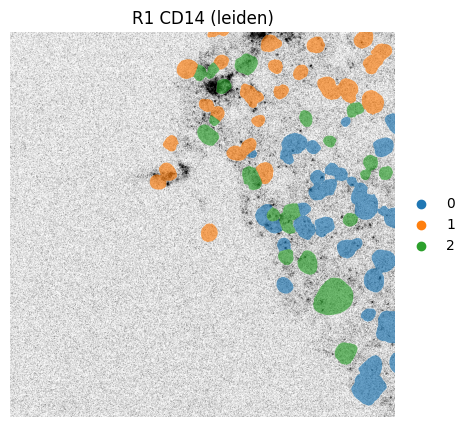

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

channel = "R1 CD14"
# normalization parameters for visualization (underlying image not changed)
se = _get_spatial_element(sdata, layer="HumanLiverH35")
channel_idx = np.where(sdata["HumanLiverH35"].c.data == channel)[0].item()
vmax = da.percentile(se.data[channel_idx].flatten(), q=99).compute()
norm = Normalize(vmax=vmax, clip=False)

render_images_kwargs = {"cmap": "binary", "norm": norm}
render_labels_kwargs = {"fill_alpha": 0.6, "outline_alpha": 0.4}

# color by area
color = cluster_key
show_kwargs = {
    "title": f"{channel} ({color})",
    "colorbar": False,
}
ax = hp.pl.plot_spatialdata(
    sdata,
    img_layer="HumanLiverH35",
    channel=channel,
    labels_layer="segmentation_mask",
    table_layer="table_intensities",
    color=color,
    render_images_kwargs=render_images_kwargs,
    show_kwargs=show_kwargs,
    ax=ax,
)
ax.axis("off")

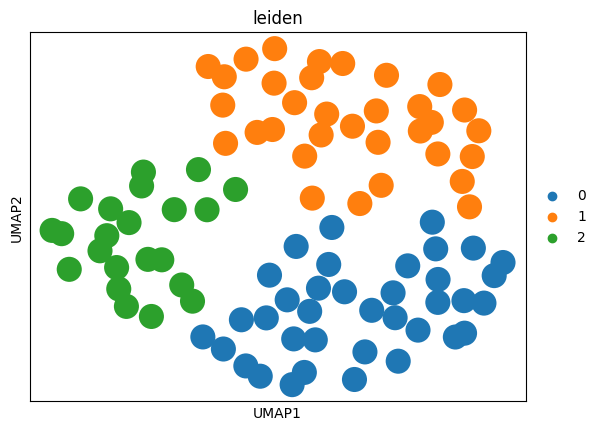

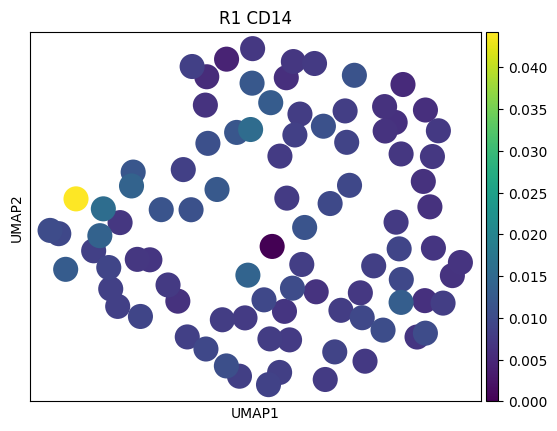

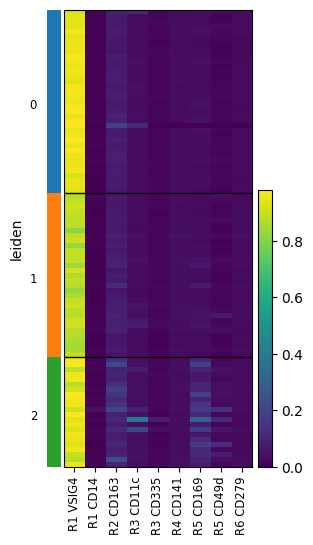

In [21]:
# visualize with scanpy
import scanpy as sc

sc.pl.umap(sdata["table_intensities"], color=cluster_key)
sc.pl.umap(sdata["table_intensities"], color="R1 CD14")
sc.pl.heatmap(
    sdata["table_intensities"],
    var_names=sdata["table_intensities"].var_names,
    groupby=cluster_key,
    swap_axes=False,
    norm=None,
)

2025-11-07 14:34:36,064 - harpy.table._cluster_intensity - INFO - Weighted (by instance size) average intensity per cluster (cluster key: 'leiden') will be stored in 'sdata[table_intensities].uns[leiden_weighted_intensity]'.
2025-11-07 14:34:36,067 - harpy.table._cluster_intensity - WARNING - Column with name 'shapeSize' not found in 'sdata[table_intensities].obs', calculating instance size for all instances in ['segmentation_mask'].
2025-11-07 14:34:36,068 - harpy.table._cluster_intensity - INFO - Calculating instance size from provided labels layer 'segmentation_mask'
/Users/arnedf/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/arnedf/VIB/harpy/.venv_harpy/lib/python3.12/site-packages/spatialdata/models/models.py:1183: UserWarning: Converting `region_key: fov_labels` to categorical dtype.
  convert_region_column_to_categorical(ad

,leiden,R1 VSIG4,R1 CD14,R2 CD163,R3 CD11c,R3 CD335,R4 CD141,R5 CD169,R5 CD49d,R6 CD279
0,0,0.954299,0.008362,0.074432,0.034132,0.014923,0.032243,0.035451,0.015137,0.028149
1,1,0.881405,0.008194,0.076958,0.036107,0.014672,0.034221,0.036067,0.017595,0.030097
2,2,0.943359,0.010718,0.125161,0.060092,0.017172,0.033411,0.119459,0.036574,0.029185


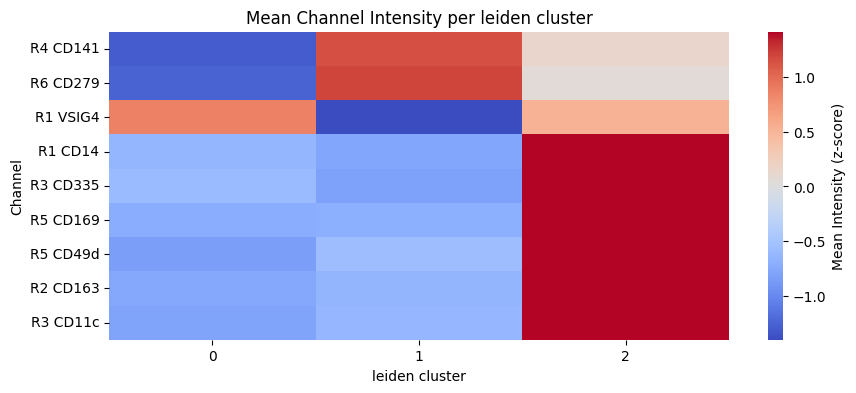

In [22]:
# calculate the mean itensity per leiden cluster
sdata = hp.tb.cluster_intensity(
    sdata,
    table_layer="table_intensities",
    labels_layer="segmentation_mask",
    output_layer="table_intensities",
    cluster_key=cluster_key,
    cluster_key_uns=f"{cluster_key}_weighted_intensity",
    overwrite=True,
)

display(sdata["table_intensities"].uns[f"{cluster_key}_weighted_intensity"])

ax = hp.pl.cluster_intensity_heatmap(
    sdata, table_layer="table_intensities", cluster_key="leiden", z_score=True, figsize=(10, 4)
)